# Random forest

In [2]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [3]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predicand)

In [6]:
# dem_da = xr.open_dataset(
#     path + "/data/energy_demand/daily_demand_2010-2020_stl.nc"
# )["demand_stl"]

In [7]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/EU_daily_demand_2010-2020_detrended.nc"
)["demand_dt"]
dem_da = dem_da.expand_dims({"region": ["EU"]})

Predictors. Load everything from relevant directory.

In [9]:
files = fn.get_predictor_files("EU", "pop_dens_mask")

In [59]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [60]:
pred_ds.data_vars

Data variables:
    hdd       (time) float64 8.808 9.803 11.03 12.42 ... 8.312 7.498 7.14 4.48
    t2min     (time) float64 nan 275.6 274.4 272.7 ... 276.8 277.7 277.4 280.6
    q         (time) float64 5.097 4.794 4.397 3.954 ... 5.48 5.54 5.976 6.661
    rh        (time) float64 83.3 82.79 82.81 81.51 ... 85.94 82.65 86.8 81.35
    msdwswrf  (time) float64 44.56 43.21 51.47 53.18 ... 31.66 34.83 29.22 37.78
    t2m       (time) float64 279.4 278.4 277.2 275.8 ... 279.8 280.6 281.0 283.6
    mtpr      (time) float64 2.423e-05 5.883e-05 ... 4.854e-05 5.122e-05
    t2max     (time) float64 nan 280.8 279.0 278.0 ... 282.4 282.6 283.8 285.9
    w10       (time) float64 4.219 4.438 3.654 3.395 ... 4.548 4.841 4.735 4.957
    cdd       (time) float64 0.02074 0.02073 0.02073 ... -0.02073 -0.02074

In [61]:
pred_ds = pred_ds.expand_dims({"region": ["EU"]})

### Just work with a few predictors for now

In [62]:
pred_ds = pred_ds[["t2m", "rh", "w10", "q"]]

## Prepare data

In [63]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
time_cols = ["is_weekend"]
# time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [64]:
# region_dfs["NEM"].head()

In [65]:
region_dfs["EU"].head()

,demand,is_weekend,t2m,rh,w10,q
2010-01-01,5.593047e+06,0,274.480321,86.385824,3.313282,3.845812
2010-01-02,6.103206e+06,1,273.276286,83.323078,2.826598,3.340677
2010-01-03,6.100054e+06,1,271.966035,82.310210,2.124813,3.041316
2010-01-04,7.152673e+06,0,271.216787,87.481832,2.196390,3.170007
2010-01-05,7.421715e+06,0,271.693463,87.681658,2.274438,3.339329


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [66]:
# len(region_dfs["NEM"])

In [67]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice("2015", "2015")).time.values.shape[0]

In [68]:
test_len

365

In [69]:
train_X, test_X, train_y, test_y = fn.split(
    region_dfs["EU"],
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [97]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [98]:
rf = ExtraTreesRegressor(
    # n_estimators=best_params["n_estimators"],
    # min_samples_leaf=best_params["min_samples_leaf"],
    # max_depth=best_params["max_depth"],
    # max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
    # criterion="absolute_error"
)

In [99]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, "2010", "2014")

[2010 2010 2010 ... 2014 2014 2014]


In [100]:
model = mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

In [101]:
model.subsets_

{1: {'feature_idx': (1,),
  'cv_scores': array([-663386.68713889, -612979.13347613, -566951.33977582,
         -613192.40074554, -581745.81699937]),
  'avg_score': -607651.0756271507,
  'feature_names': ('1',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([-375682.73507131, -313880.85080597, -322807.24465033,
         -337666.65218846, -316701.13307751]),
  'avg_score': -333347.72315871733,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([-334097.36761688, -272771.33848656, -281614.70218671,
         -255094.740548  , -266779.52827991]),
  'avg_score': -282071.53542361286,
  'feature_names': ('0', '1', '2')},
 4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([-317616.42753172, -261874.22656556, -281051.36493446,
         -242193.66575759, -260657.7171658 ]),
  'avg_score': -272678.68039102614,
  'feature_names': ('0', '1', '2', '3')},
 5: {'feature_idx': (0, 1, 2, 3, 4),
  'cv_scores': array([-318008.78636773, -264145.24035233, -276363.6282

In [102]:
model.k_feature_idx_

(0, 1, 2, 3)

In [103]:
# selected_features = list(region_dfs["EU"].columns[1:][model.get_support()])
# print(selected_features)

In [104]:
selected_features = region_dfs["EU"].columns[1:][list(model.k_feature_idx_)]
print(selected_features)

Index(['is_weekend', 't2m', 'rh', 'w10'], dtype='object')


In [105]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-663386.6871388941, -612979.1334761293, -5669...",-607651.075627,"(1,)",42601.544005,33145.44855,16572.724275
2,"(0, 1)","[-375682.7350713114, -313880.8508059749, -3228...",-333347.723159,"(0, 1)",29185.309772,22707.162523,11353.581262
3,"(0, 1, 2)","[-334097.3676168821, -272771.3384865589, -2816...",-282071.535424,"(0, 1, 2)",35222.517737,27404.315424,13702.157712
4,"(0, 1, 2, 3)","[-317616.42753171636, -261874.22656556405, -28...",-272678.680391,"(0, 1, 2, 3)",32919.905464,25612.804849,12806.402424
5,"(0, 1, 2, 3, 4)","[-318008.786367728, -264145.2403523291, -27636...",-274025.693943,"(0, 1, 2, 3, 4)",30605.593487,23812.191506,11906.095753


In [106]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

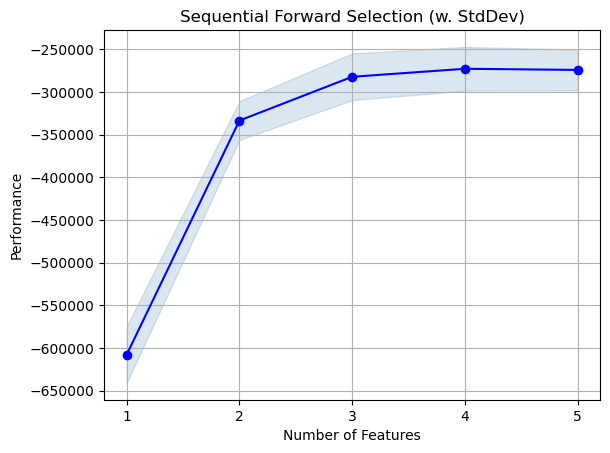

In [107]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [46]:
# parameters = {
#     "n_estimators": randint(200, 500), # no. trees in the forest
#     "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
#     "max_depth" : randint(5, 50), # max depth of each tree
#     # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
#     "max_leaf_nodes": randint(20, 100) # size of tree, how many end nodes
# }

In [47]:
retain = ["demand"] + selected_features

In [48]:
final_features = region_dfs["EU"][retain]

In [56]:
train_X, test_X, train_y, test_y = fn.split(
    final_features,
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [57]:
# very restricted space for testing
parameters = {
    "n_estimators": randint(10, 12), # no. trees in the forest
}

In [58]:
rf = ExtraTreesRegressor()

In [69]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, "2010", "2014")

[2010 2010 2010 ... 2014 2014 2014]


In [70]:
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=1
)

In [71]:
best_params

{'n_estimators': 10}

## Finalise model

In [73]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    # min_samples_leaf=best_params["min_samples_leaf"],
    # max_depth=best_params["max_depth"],
    # max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [76]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [77]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [78]:
pred_train.shape

(1826,)

In [79]:
pred_test.shape

(365,)

## Evaluate performance

In [80]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [81]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [144]:
train_scores

[0.011277383762600235,
 0.9765867020133837,
 94731.16225310811,
 18367000893.65051,
 0.013643889796831146,
 68775.18798309751]

In [82]:
train_scores

[0.9999954929698238,
 62.229694860822114,
 3535624.384134159,
 9.202062941555382e-06,
 9.313225746154785e-10]

In [84]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [146]:
test_scores

[0.08878283314013424,
 0.7772241056175613,
 305973.0486732941,
 149538320535.62732,
 0.042241479485329234,
 266560.99227178656]

In [85]:
test_scores

[0.653045510223628,
 360381.3096145923,
 232893203491.69717,
 0.049795522641578494,
 286349.0882836124]

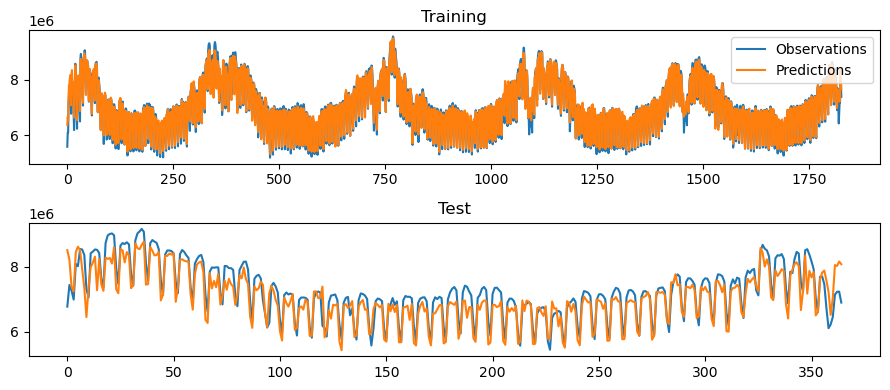

In [147]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

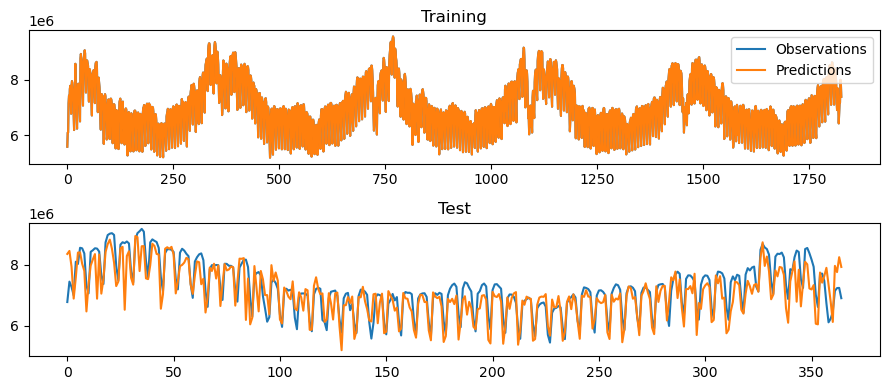

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

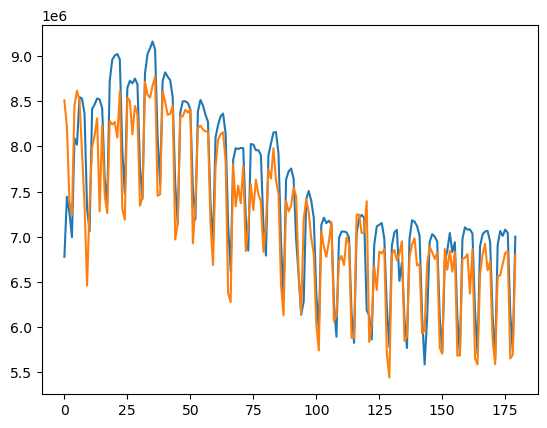

In [148]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [87]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=2,
)

In [88]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=2,
)

In [89]:
perm_train

{'importances_mean': array([0.69796964, 1.42670537]),
 'importances_std': array([0.00748129, 0.01167371]),
 'importances': array([[0.69048834, 0.70545093],
        [1.41503166, 1.43837908]])}

In [90]:
perm_test

{'importances_mean': array([0.69735678, 0.91425193]),
 'importances_std': array([0.04208141, 0.04297945]),
 'importances': array([[0.73943819, 0.65527537],
        [0.87127248, 0.95723138]])}

In [92]:
fn.print_perm_imp(perm_train, selected_features)

t2m      1.427 +/- 0.012
is_weekend 0.698 +/- 0.007


In [93]:
fn.print_perm_imp(perm_test, selected_features)

t2m      0.914 +/- 0.043
is_weekend 0.697 +/- 0.042
